# SSGP

Port of GPJax's implementation: https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi/

From this paper: https://arxiv.org/abs/1309.6835

GPjax is pip installable.

In [1]:
import os

# XLA_FLAGS="--xla_force_host_platform_device_count=8"

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax

jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [112]:
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
import numpy as np
import tensorflow_probability.substrates.jax as tfp

# from examples.utils import use_mpl_style

config.update("jax_enable_x64", True)

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    import gpjax.kernels as jk


tfb = tfp.bijectors

key = jr.key(123)

# set the default style for plotting
# use_mpl_style()
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# simulated data set

In [128]:
n = 50_000
noise = 0.2

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).reshape(-1, 1)
#f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x) # original
f = lambda x: jnp.sin(1 * x) + jnp.cos(0.5 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

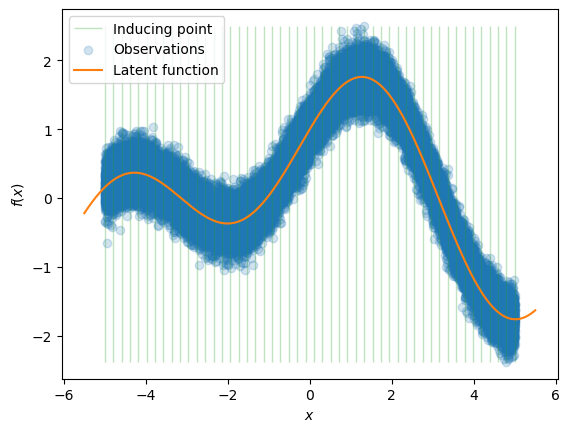

In [129]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots()
ax.vlines(
    z,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)
ax.scatter(x, y, alpha=0.2, color=cols[0], label="Observations")
ax.plot(xtest, f(xtest), color=cols[1], label="Latent function")
ax.legend()
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$");

In [130]:
meanf = gpx.mean_functions.Zero()
likelihood = gpx.likelihoods.Gaussian(num_datapoints=n)
kernel = jk.RBF()  # 1-dimensional inputs
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
p = prior * likelihood
q = gpx.variational_families.VariationalGaussian(posterior=p, inducing_inputs=z)

from gpjax.dataset import Dataset

D2 = Dataset(D.X[::20, :], D.y[::20])

gpx.objectives.elbo(q, D2)

Array(-14295845.45878681, dtype=float64)

In [116]:
%%timeit

gpx.objectives.elbo(q, D2)

88.5 ms ± 9.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Train

In [123]:
schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.02,
    warmup_steps=75,
    decay_steps=5000,
    end_value=0.001,
)

opt_posterior, history = gpx.fit(
    model=q,
    # we are minimizing the elbo so we negate it
    objective=lambda p, d: -gpx.objectives.elbo(p, d),
    train_data=D,
    optim=ox.adam(learning_rate=schedule),
    num_iters=100_000 * 500 // 50_000,
    key=jr.key(42),
    batch_size=500,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

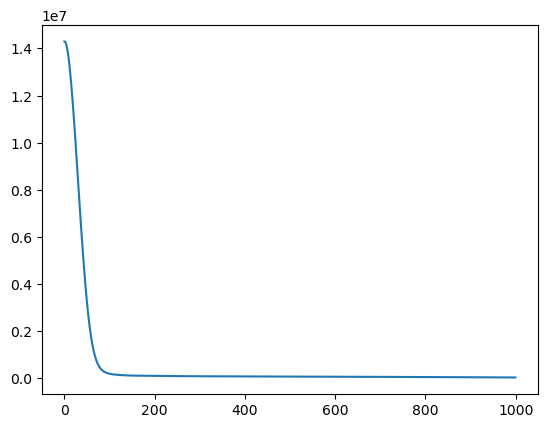

In [124]:
plt.plot(history)

In [125]:
history[-1]

Array(21181.46054085, dtype=float64)

# Generate predictions

In [126]:
latent_dist = opt_posterior(xtest)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

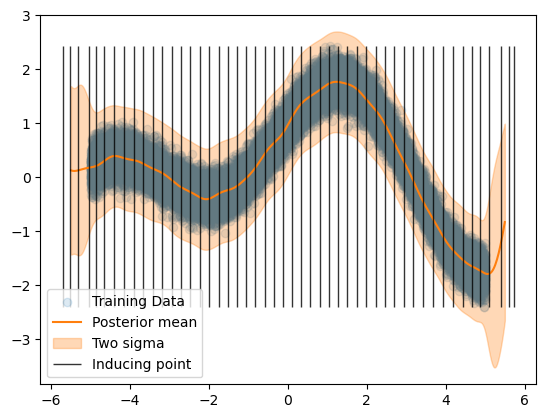

In [127]:
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.15, label="Training Data", color=cols[0])
ax.plot(xtest, meanf, label="Posterior mean", color=cols[1])
ax.fill_between(
    xtest.flatten(),
    meanf - 2 * sigma,
    meanf + 2 * sigma,
    alpha=0.3,
    color=cols[1],
    label="Two sigma",
)
ax.vlines(
    opt_posterior.inducing_inputs.value,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.8,
    linewidth=1,
    label="Inducing point",
    color="k",
)
ax.legend();

# (Very) rough port of implementation

In [177]:
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.gp.util import stabilize

Xd = np.asarray(D.X)
yd = np.asarray(D.y)


class VariationalGaussian:
    def __init__(
        self,
        mean_func,
        cov_func,
        inducing_inputs,
        variational_mean,
        variational_root_covariance,
        jitter=1e-6,
    ):
        self.mean_func = mean_func
        self.cov_func = cov_func
        self.inducing_inputs = inducing_inputs
        self.variational_mean = variational_mean
        self.variational_root_covariance = variational_root_covariance

    def kl_divergence(self):
        mu = self.variational_mean
        sqrt = self.variational_root_covariance
        z = self.inducing_inputs

        muz = self.mean_func(z)
        Kzz = self.cov_func(z)
        return self.kl_mvn(mu.flatten(), sqrt, muz, Kzz)

    @staticmethod
    def kl_mvn(mu1, K1, mu2, K2):
        d = mu2 - mu1

        K1 = stabilize(K1)
        K2 = stabilize(K2)

        L1 = pt.linalg.cholesky(K1, lower=True)
        L2 = pt.linalg.cholesky(K2, lower=True)

        logdet1 = 2 * pt.sum(pt.log(pt.diag(L1)))
        logdet2 = 2 * pt.sum(pt.log(pt.diag(L2)))

        def solve(B):
            return pt.linalg.solve_triangular(
                L2.T, pt.linalg.solve_triangular(L2, B, lower=True), lower=False
            )

        term1 = pt.trace(solve(K1))
        term2 = logdet2 - logdet1
        term3 = d.T @ solve(d)
        return (term1 + term2 + term3 - d.shape[0]) / 2.0

    def predict(self, t):
        mu = self.variational_mean.flatten()
        sqrt = self.variational_root_covariance
        z = self.inducing_inputs

        muz = self.mean_func(z)
        Kzz = stabilize(self.cov_func(z))
        Lz = pt.linalg.cholesky(Kzz)

        Ktt = stabilize(self.cov_func(t))
        Kzt = self.cov_func(z, t)
        mut = self.mean_func(t)

        Lz_inv_Kzt = pt.linalg.solve_triangular(Lz, Kzt, lower=True)  # Lz⁻¹ Kzt
        Kzz_inv_Kzt = pt.linalg.solve_triangular(Lz.T, Lz_inv_Kzt, lower=False)  # Kzz⁻¹ Kzt
        Ktz_Kzz_inv_sqrt = pt.matmul(Kzz_inv_Kzt.T, sqrt)  # Ktz Kzz⁻¹ sqrt

        mean = mut + pt.matmul(Kzz_inv_Kzt.T, mu - muz)  # μt + Ktz Kzz⁻¹ (μ - μz)
        covariance = stabilize(
            Ktt
            - pt.matmul(Lz_inv_Kzt.T, Lz_inv_Kzt)
            + pt.matmul(Ktz_Kzz_inv_sqrt, Ktz_Kzz_inv_sqrt.T)
        )
        return mean, covariance
        # return pm.MvNormal.dist(mu=mean,  cov=covariance)


def variational_expectation(variational_family, X, y, sigma):
    # Unpack training batch

    # Variational distribution q(f(·)) = N(f(·); μ(·), Σ(·, ·))
    q = variational_family
    # mean, covariance = q.predict(X)
    # variance = pt.diag(covariance)

    # func = pt.vectorize(q.predict, "(n, k) -> (n, ), (n, )")
    func = pt.vectorize(q.predict, "(k, a) -> (a), (a, a)")
    X = pt.as_tensor(X)
    mean, variance = func(X[..., None])
    mean = mean.ravel()
    variance = variance.ravel()

    # mean = pytensor.printing.Print("mean")(mean)
    # variance = pytensor.printing.Print("variance")(variance)

    ## integrate expectation
    sq_error = pt.square(y - mean[:, None])
    expectation = -0.5 * pt.sum(
        pt.log(2.0 * pt.pi) + pt.log(sigma**2) + (sq_error + variance[:, None]) / sigma**2, axis=1
    )
    return expectation


with pm.Model() as model:
    X = pm.Data("X", Xd)
    y = pm.Data("y", yd)

    eta = pm.Exponential("eta", scale=1.0)
    #ell = pm.InverseGamma("ell", mu=2.0, sigma=5.0)
    ell = pm.HalfFlat("ell")
    # eta = 1.0
    # ell = 1.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    # c = pm.Normal("c", mu=0.0, sigma=10.0)
    c = 0.0
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 50
    z = np.linspace(-5, 5, n_inducing)[:, None]

    #     gp = pm.GP(cov_func=cov_func)
    #     pm.Poisson(mu=f, observed=y)

    #     fit = pm.fit_variational_gp(X=X)

    # inducing_inputs = z
    # variational_mean = pt.zeros((n_inducing, 1))
    # variational_root_covariance = pt.eye(n_inducing)

    # inducing_inputs = pt.tensor("inducing_inputs", shape=(n_inducing, Xd.shape[1]))
    # variational_mean = pt.tensor("variational_mean", shape=(n_inducing, Xd.shape[1]))
    # variational_root_covariance = pt.tensor("variational_root_covariance", shape=(n_inducing, n_inducing))

    inducing_inputs = pm.Flat("inducing_inputs", shape=(n_inducing, Xd.shape[1]))
    variational_mean = pm.Flat("variational_mean", shape=(n_inducing, Xd.shape[1]))
    # variational_root_covariance = pm.Flat("variational_root_covariance", shape=(n_inducing, n_inducing))
    variational_root_chol, _, _ = pm.LKJCholeskyCov(
        "vrc", n=n_inducing, eta=1, sd_dist=pm.HalfNormal.dist(sigma=1)
    )
    variational_root_covariance = variational_root_chol @ variational_root_chol.T

    sigma = pm.Exponential("sigma", 1)

    variational_family = VariationalGaussian(
        mean_func, cov_func, inducing_inputs, variational_mean, variational_root_covariance
    )

    # def elbo(model):
    #    pass

    def elbo(X, y):
        ## compute KL
        kl = variational_family.kl_divergence()
        # print("kl", kl.eval())

        ## Compute variational expectation
        var_exp = variational_expectation(variational_family, X, y, sigma)
        # print("var_exp", pt.sum(var_exp).eval())

        n, b = X.shape[0].eval(), X.shape[0]
        return (n / b) * pt.sum(var_exp).squeeze() - kl

    loss = -elbo(X, y)

# Trying to find where the renaming happens
- starting in jax_funcify
- step through here: https://github.com/pymc-devs/pytensor/blob/main/pytensor/link/utils.py#L666
- saw stuff about renaming.

In [178]:
def make_training_step_fn(
    model,
    loss,
    optimizer,
    batch_size=512,
    n_devices=1,
):
    point = model.initial_point()
    [loss_w_values] = model.replace_rvs_by_values([loss])
    # [loss2], joined_inputs = pm.pytensorf.join_nonshared_inputs(
    #    point=point, outputs=[loss_w_values], inputs=model.continuous_value_vars# + pm.inputvars(loss) # for pt.tensor
    # )
    # replace X, y with their minibatch
    X, y = model["X"], model["y"]
    X_batch = pt.tensor("X_batch", shape=(batch_size, X.get_value().shape[1]))
    y_batch = pt.tensor("y_batch", shape=(batch_size, 1))

    loss2 = pytensor.graph.graph_replace(
        loss_w_values,
        replace={
            X: X_batch,
            y: y_batch,
        },
    )

    from pymc.sampling.jax import get_jaxified_graph

    f_loss_jax = get_jaxified_graph(
        [X_batch, y_batch, *model.continuous_value_vars], outputs=[loss2]
    )
    #f_loss_jax = pytensor.function(
    #    [X_batch, y_batch, *model.continuous_value_vars],
    #    outputs=[loss2],
    #    mode='JAX'
    #)

    def f_loss(X, y, params):
        return f_loss_jax(X, y, *params)[0]

    from functools import partial

    # @partial(jax.pmap, axis_name="device")
    @jax.jit
    def training_step(X, y, params, optimizer_state):
        loss, grads = jax.value_and_grad(f_loss, 2)(X, y, params)

        ## with partial(jax.pmap), comment if that decor is gone
        # loss = jax.lax.psum(loss, axis_name="device")
        # grads = jax.lax.psum(grads, axis_name="device")

        updates, optimizer_state = optimizer.update(grads, optimizer_state, params)

        params = optax.apply_updates(params, updates)
        return params, optimizer_state, loss

    return training_step

In [179]:
import optax

schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.02,
    warmup_steps=75,
    decay_steps=2000,
    end_value=0.001,
)

batch_size = 500

optimizer = optax.adam(learning_rate=3e-5)
training_step = make_training_step_fn(model, loss, optimizer, batch_size=batch_size)
"""
params = dict(
    eta_log_=-1.0,
    ell_log_=-1.0,
    sigma_log_=-1.0,
    inducing_inputs=z,
    variational_mean=np.zeros((n_inducing, 1)),
    # variational_root_covariance=np.eye(n_inducing),
)
params["vrc_cholesky_cov_packed_"] = np.zeros((n_inducing * (n_inducing - 1) // 2) + n_inducing)
"""
initial_point = model.initial_point()
initial_point["inducing_inputs"] = z
initial_point["ell_log__"] = 1.0
initial_point["eta_log__"] = 1.0
initial_point["sigma_log__"] = 1.0

params = tuple(initial_point.values())

optimizer_state = optimizer.init(params)

## for use with pmap (:6, thats 6 CPUs)
# optimizer_state = jax.device_put_replicated(optimizer_state, jax.devices()[:6])

# new_params, new_state, loss_value = training_step(Xd[:batch_size, :], yd[:batch_size], params, optimizer_state)

In [180]:
t_values = np.linspace(-6, 8, 200)[:, None]
t = pt.tensor("t", shape=(None, 1))
mu, cov = variational_family.predict(t)
mu_value, cov_value = model.replace_rvs_by_values([mu, cov])

inputs = pm.inputvars([mu_value, cov_value])

f_predict = pytensor.function(
    inputs=inputs,
    outputs=[mu_value, cov_value],
    on_unused_input="ignore",
    mode="FAST_RUN",
)

input_names = [x.name for x in inputs]

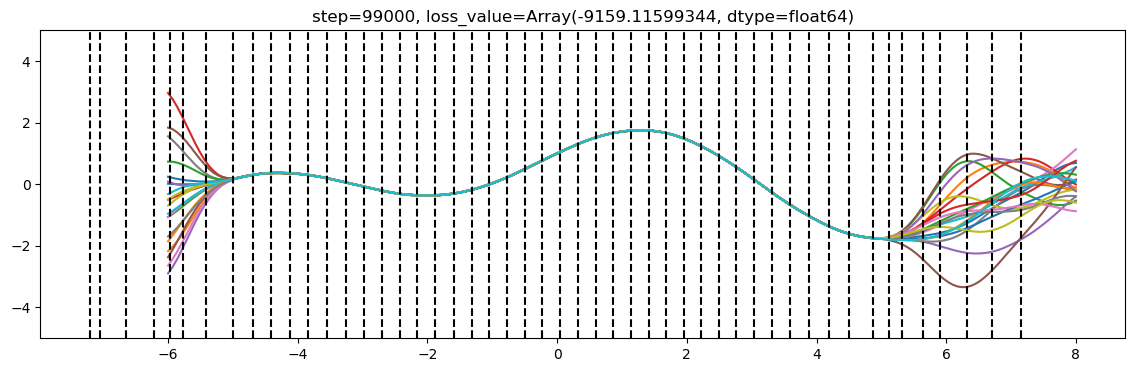

In [189]:
# n_steps = 10_000
import jax
from scipy import stats
from IPython.display import clear_output


n_steps = 100_000
var_names = model.initial_point().keys()

loss_history = []
idx = 0
for step in range(n_steps):
    #batch_slice = slice(idx, idx + batch_size)
    batch_slice = np.random.choice(Xd.shape[0], size=batch_size, replace=False)

    X, y = Xd[batch_slice, :], yd[batch_slice]
    #idx = (idx + batch_size) % Xd.shape[0]

    
    params, optimizer_state, loss_value = training_step(X, y, params, optimizer_state)
    loss_history.append(loss_value)


    result_dict = dict(zip(var_names, params))
    

    if step % 1000 == 0:

        clear_output(wait=True)
        
        mu_pred, cov_pred = f_predict(
            **{k: v for k, v in result_dict.items() if k in input_names}, t=t_values
        )
        
        d = stats.multivariate_normal(mean=mu_pred, cov=cov_pred, allow_singular=True)
        samples = d.rvs(20)


        fig, ax = plt.subplots(figsize=(14, 4))
        ax.plot(t_values, samples.T)
        #ax.scatter(Xd, yd, alpha=0.1);
        
        for point in result_dict["inducing_inputs"]:
            ax.axvline(point, color="k", linestyle="--")
        
        ax.set_ylim([-5, 5])
        ax.set_title(f"{step=}, {loss_value=}")
        plt.show()
        
        #print(np.mean(loss_history[-25:]))

        #print(result_dict["inducing_inputs"][0:10].ravel())

In [190]:
result_dict

{'eta_log__': Array(-0.25442271, dtype=float64),
 'ell_log__': Array(-0.44051677, dtype=float64),
 'inducing_inputs': Array([[-7.22525644],
        [-7.06030705],
        [-6.65930565],
        [-6.21984225],
        [-5.97751534],
        [-5.7727651 ],
        [-5.41746787],
        [-4.99629401],
        [-4.69133218],
        [-4.41281015],
        [-4.1224026 ],
        [-3.83840514],
        [-3.54431838],
        [-3.24994454],
        [-2.97905523],
        [-2.7025435 ],
        [-2.42381894],
        [-2.15641483],
        [-1.87736697],
        [-1.59271498],
        [-1.31272551],
        [-1.04314626],
        [-0.76894222],
        [-0.49308811],
        [-0.22527277],
        [ 0.04351211],
        [ 0.32131074],
        [ 0.59280756],
        [ 0.86496081],
        [ 1.13891509],
        [ 1.41112501],
        [ 1.68148979],
        [ 1.95295019],
        [ 2.22294444],
        [ 2.49233765],
        [ 2.76345058],
        [ 3.03972357],
        [ 3.31626678],
        [

In [188]:
sigma = np.exp(-1.26)
eta = np.exp(1.18)
ell = np.exp(-0.66)

sigma, eta, ell

(0.2836540264997704, 3.2543742028896707, 0.5168513344916992)

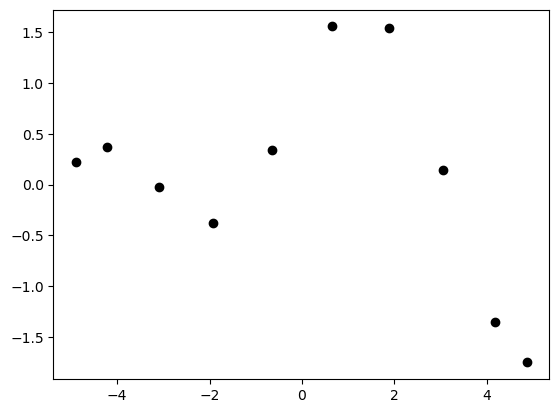

In [170]:
chol = pm.expand_packed_triangular(10, np.asarray(result_dict["vrc_cholesky-cov-packed__"]), lower=True)
K = (chol @ chol.T).eval()


plt.plot(result_dict["inducing_inputs"], result_dict['variational_mean'], "ok")

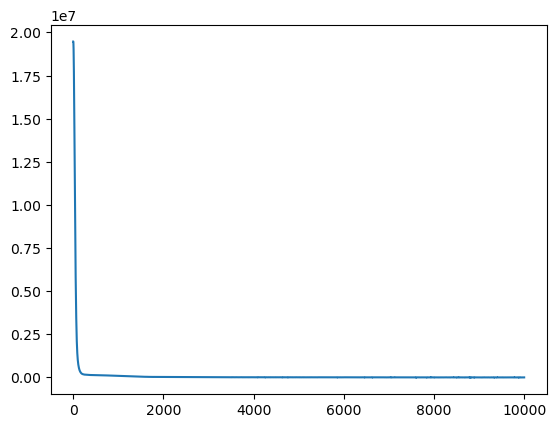

In [151]:
plt.plot(loss_history)
#plt.ylim([0, 1e7]);

In [107]:
np.exp(-1), np.exp(1)

(0.36787944117144233, 2.718281828459045)

In [105]:
result_dict

{'eta_log__': Array(1.0296049, dtype=float64),
 'ell_log__': Array(-1.03455876, dtype=float64),
 'inducing_inputs': Array([[-5.92085938],
        [-5.76556948],
        [-5.54753733],
        [-5.25133809],
        [-4.9722141 ],
        [-4.74102203],
        [-4.50422553],
        [-4.25682667],
        [-4.00886829],
        [-3.7550514 ],
        [-3.50860204],
        [-3.26671415],
        [-3.01726975],
        [-2.77689381],
        [-2.53324632],
        [-2.28480131],
        [-2.03670396],
        [-1.78093812],
        [-1.54879191],
        [-1.30286231],
        [-1.05709609],
        [-0.80560454],
        [-0.57184956],
        [-0.32248749],
        [-0.07869392],
        [ 0.163558  ],
        [ 0.4063406 ],
        [ 0.64234113],
        [ 0.8877544 ],
        [ 1.12471262],
        [ 1.36833052],
        [ 1.61062751],
        [ 1.8462946 ],
        [ 2.08696027],
        [ 2.33657851],
        [ 2.58027625],
        [ 2.82541634],
        [ 3.07197923],
        [ 3

# Predict

In [60]:
t_values = np.linspace(-6, 8, 200)[:, None]
t = pt.tensor("t", shape=(None, 1))
mu, cov = variational_family.predict(t)
mu_value, cov_value = model.replace_rvs_by_values([mu, cov])

inputs = pm.inputvars([mu_value, cov_value])

f_predict = pytensor.function(
    inputs=inputs,
    outputs=[mu_value, cov_value],
    on_unused_input="ignore",
    mode="FAST_RUN",
)

input_names = [x.name for x in inputs]

mu_pred, cov_pred = f_predict(
    **{k: v for k, v in result_dict.items() if k in input_names}, t=t_values
)

from scipy import stats
d = stats.multivariate_normal(mean=mu_pred, cov=cov_pred)
samples = d.rvs(20)

In [62]:
from scipy import stats

d = stats.multivariate_normal(mean=mu_pred, cov=cov_pred)
samples = d.rvs(20)

(-5.0, 5.0)

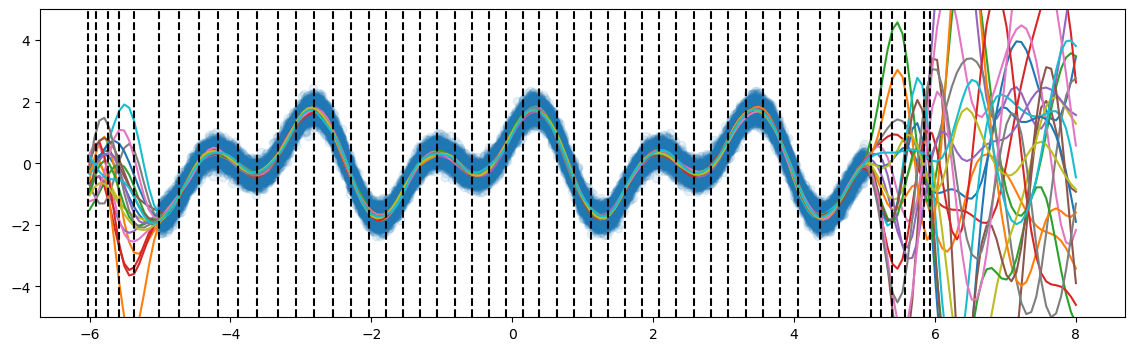

In [63]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t_values, samples.T)
ax.scatter(Xd, yd, alpha=0.1);

for point in result_dict["inducing_inputs"]:
    ax.axvline(point, color="k", linestyle="--")

ax.set_ylim([-5, 5])

In [48]:
z

array([[-5.        ],
       [-4.79591837],
       [-4.59183673],
       [-4.3877551 ],
       [-4.18367347],
       [-3.97959184],
       [-3.7755102 ],
       [-3.57142857],
       [-3.36734694],
       [-3.16326531],
       [-2.95918367],
       [-2.75510204],
       [-2.55102041],
       [-2.34693878],
       [-2.14285714],
       [-1.93877551],
       [-1.73469388],
       [-1.53061224],
       [-1.32653061],
       [-1.12244898],
       [-0.91836735],
       [-0.71428571],
       [-0.51020408],
       [-0.30612245],
       [-0.10204082],
       [ 0.10204082],
       [ 0.30612245],
       [ 0.51020408],
       [ 0.71428571],
       [ 0.91836735],
       [ 1.12244898],
       [ 1.32653061],
       [ 1.53061224],
       [ 1.73469388],
       [ 1.93877551],
       [ 2.14285714],
       [ 2.34693878],
       [ 2.55102041],
       [ 2.75510204],
       [ 2.95918367],
       [ 3.16326531],
       [ 3.36734694],
       [ 3.57142857],
       [ 3.7755102 ],
       [ 3.97959184],
       [ 4

In [138]:
params = tuple(model.initial_point().values())
f_loss_jax = get_jaxified_graph(model.value_vars, [model.logp()])

def f_loss(params):
    return f_loss_jax(*params)[0]

@jax.jit
def f_loss_and_grad(params):
    return jax.value_and_grad(f_loss)(params)

#f_loss_and_grad(params)


In [127]:
params = tuple(model.initial_point().values())
f_loss_jax = get_jaxified_graph(model.value_vars, [model.logp()])

def f_loss(params):
    return f_loss_jax(*params)[0]

@jax.jit
def f_loss_and_grad(params):
    return jax.value_and_grad(f_loss)(params)

#f_loss_and_grad(params)


(Array(-1009.30791445, dtype=float64),
 (Array(0., dtype=float64),
  Array(-1., dtype=float64),
  Array([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], dtype=float64),
  Array([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
  

In [128]:
model.initial_point().keys()

dict_keys(['eta_log__', 'ell_log__', 'inducing_inputs', 'variational_mean', 'vrc_cholesky-cov-packed__', 'sigma_log__'])

In [13]:
model.replace_rvs_by_values?

Signature: model.replace_rvs_by_values(graphs: 'Sequence[TensorVariable]', **kwargs) -> 'list[TensorVariable]'
Docstring:
Clone and replace random variables in graphs with their value variables.

This will *not* recompute test values in the resulting graphs.

Parameters
----------
graphs : array_like
    The graphs in which to perform the replacements.

Returns
-------
array_like
File:      /opt/miniconda3/envs/ssvi/lib/python3.11/site-packages/pymc/model/core.py
Type:      method

In [95]:
point = model.initial_point()
[loss_w_values] = model.replace_rvs_by_values([loss])
# [loss2], joined_inputs = pm.pytensorf.join_nonshared_inputs(
#    point=point, outputs=[loss_w_values], inputs=model.continuous_value_vars# + pm.inputvars(loss) # for pt.tensor
# )
# replace X, y with their minibatch
X, y = model["X"], model["y"]
X_batch = pt.tensor("X_batch", shape=(batch_size, X.get_value().shape[1]))
y_batch = pt.tensor("y_batch", shape=(batch_size, 1))

loss2 = pytensor.graph.graph_replace(
    loss_w_values,
    replace={
        X: X_batch,
        y: y_batch,
    },
)

from pymc.sampling.jax import get_jaxified_graph

f_loss_jax = get_jaxified_graph(
    [X_batch, y_batch, *model.continuous_value_vars], outputs=[loss2]
)

In [119]:
import pytensor
pytensor.__version__

'2.26.3'

In [ ]:
def get_jaxified_graph(
    inputs: list[TensorVariable] | None = None,
    outputs: list[TensorVariable] | None = None,
) -> list[TensorVariable]:
    """Compile a PyTensor graph into an optimized JAX function."""
    graph = _replace_shared_variables(outputs) if outputs is not None else None

    fgraph = FunctionGraph(inputs=inputs, outputs=graph, clone=True)
    # We need to add a Supervisor to the fgraph to be able to run the
    # JAX sequential optimizer without warnings. We made sure there
    # are no mutable input variables, so we only need to check for
    # "destroyers". This should be automatically handled by PyTensor
    # once https://github.com/aesara-devs/aesara/issues/637 is fixed.
    fgraph.attach_feature(
        Supervisor(
            input
            for input in fgraph.inputs
            if not (hasattr(fgraph, "destroyers") and fgraph.has_destroyers([input]))
        )
    )
    mode.JAX.optimizer.rewrite(fgraph)

    # We now jaxify the optimized fgraph
    return jax_funcify(fgraph)

In [21]:
import pytensor
from pymc.pytensorf import rewrite_pregrad
from pymc.sampling.jax import get_jaxified_graph

In [41]:
with pm.Model() as model:
    x = pm.Flat("x-x__")
    mu = pm.Lognormal("mu") + x
    sigma = pm.HalfNormal("sigma-sigma")
    pm.Normal("y", mu=mu, sigma=sigma, observed=[1.0, 2.0, 3.0])

f_loss_jax = get_jaxified_graph(model.value_vars, [model.logp()])
f_loss_jax

<function pytensor.link.utils.jax_funcified_fgraph(x_x_, mu_log_, sigma_sigma_log_)>

In [17]:
f_loss_jax = pytensor.function(model.value_vars, outputs=model.logp(), mode="JAX")

In [18]:
f_loss_jax

In [108]:
logp = rewrite_pregrad(model.logp())
dlogp = pt.grad(logp, model.value_vars)
#dlogp = pt.concatenate([x.ravel() for x in dlogp], axis=0)

f_loss_jax = pytensor.function(model.value_vars, outputs=[logp, *dlogp], mode="JAX")
f_loss_jax(**model.initial_point())

[Array(-5.71164064, dtype=float64),
 Array(1.05383635, dtype=float64),
 Array(1.23748238, dtype=float64),
 Array(-0.62980965, dtype=float64)]

In [110]:
model_point = model.initial_point()

In [ ]:
params = tuple(model.initial_point().values())

In [113]:
%%timeit

f_loss_jax.vm.jit_fn(*params)

26.4 μs ± 788 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [105]:


params = tuple(model.initial_point().values())
f_loss_jax = get_jaxified_graph(model.value_vars, [model.logp()])

def f_loss(params):
    return f_loss_jax(*params)[0]

@jax.jit
def f_loss_and_grad(params):
    return jax.value_and_grad(f_loss)(params)

f_loss_and_grad(params)

#def f_loss(params):
#    return jax.value_and_grad(f_loss_jax)(*params)




(Array(-5.71164064, dtype=float64),
 (Array(1.05383635, dtype=float64),
  Array(1.23748238, dtype=float64),
  Array(-0.62980965, dtype=float64)))

In [106]:
%%timeit

f_loss_and_grad(params)

27.2 μs ± 819 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [90]:
f_loss(params)

TypeError: Gradient only defined for scalar-output functions. Output was (Array(-5.71164064, dtype=float64),).

In [81]:
np.stack(tuple(model.initial_point().values()))

array([0.        , 0.49999997, 0.        ])

In [52]:
f_loss_jax(**model.initial_point())

Array(-5.71164064, dtype=float64)

In [49]:
def f_loss(params):
    return f_loss_jax(**params)

f_loss_grad = jax.grad(f_loss)

In [50]:
f_loss_grad(model.initial_point())

TracerArrayConversionError: ('The numpy.ndarray conversion method __array__() was called on traced array with shape float64[].\nSee https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError', 'Container name "mu_log__"')

TypeError: jax_funcified_fgraph() missing 3 required positional arguments: 'x_x_', 'mu_log_', and 'sigma_sigma_log_'

In [117]:
f_loss_jax = get_jaxified_graph(model.value_vars, [model.logp()])
f_loss_jax

<function pytensor.link.utils.jax_funcified_fgraph(x_x_, mu_log_, sigma_sigma_log_)>

In [112]:
get_jaxified_graph??

Signature:
get_jaxified_graph(
    inputs: list[pytensor.tensor.variable.TensorVariable] | None = None,
    outputs: list[pytensor.tensor.variable.TensorVariable] | None = None,
) -> list[pytensor.tensor.variable.TensorVariable]
Source:   
def get_jaxified_graph(
    inputs: list[TensorVariable] | None = None,
    outputs: list[TensorVariable] | None = None,
) -> list[TensorVariable]:
    """Compile a PyTensor graph into an optimized JAX function."""
    graph = _replace_shared_variables(outputs) if outputs is not None else None

    fgraph = FunctionGraph(inputs=inputs, outputs=graph, clone=True)
    # We need to add a Supervisor to the fgraph to be able to run the
    # JAX sequential optimizer without warnings. We made sure there
    # are no mutable input variables, so we only need to check for
    # "destroyers". This should be automatically handled by PyTensor
    # once https://github.com/aesara-devs/aesara/issues/637 is fixed.
    fgraph.attach_feature(
        Supervisor(
    

In [96]:
from pymc.sampling.jax import _replace_shared_variables
from pytensor.graph.fg import FunctionGraph
from pytensor.compile import SharedVariable, Supervisor, mode
from pytensor.link.jax.dispatch import jax_funcify

In [97]:
outputs = [loss2]
inputs = [X_batch, y_batch, *model.continuous_value_vars]
graph = _replace_shared_variables(outputs) if outputs is not None else None

fgraph = FunctionGraph(inputs=inputs, outputs=graph, clone=True)
#fgraph.dprint()

# We need to add a Supervisor to the fgraph to be able to run the
# JAX sequential optimizer without warnings. We made sure there
# are no mutable input variables, so we only need to check for
# "destroyers". This should be automatically handled by PyTensor
# once https://github.com/aesara-devs/aesara/issues/637 is fixed.
fgraph.attach_feature(
    Supervisor(
        input
        for input in fgraph.inputs
        if not (hasattr(fgraph, "destroyers") and fgraph.has_destroyers([input]))
    )
)
mode.JAX.optimizer.rewrite(fgraph)

# We now jaxify the optimized fgraph
f_loss_jax = jax_funcify(fgraph)

In [71]:
from pymc.sampling.jax import get_jaxified_logp, get_jaxified_graph

In [65]:
model.

In [74]:
logp_fn = get_jaxified_graph(inputs=model.value_vars, outputs=[model.logp()])

In [66]:
logp_func = get_jaxified_logp(model)

In [67]:
logp_func?

Signature: logp_func(x)
Docstring: <no docstring>
File:      /opt/miniconda3/envs/ssvi/lib/python3.11/site-packages/pymc/sampling/jax.py
Type:      function

In [59]:
from pytensor import dprint